## Import packages.

In [1]:
%matplotlib inline

# import packages
import numpy as np
import time
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
from matplotlib import gridspec

import torch
from torch import nn
from torch import distributions
from torch.nn.parameter import Parameter

from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import StandardScaler

In [2]:
# define plot properties
from cycler import cycler
import matplotlib.cm as cm

from matplotlib import rcParams
from matplotlib import rc
from mpl_toolkits.axes_grid1 import make_axes_locatable

def rgb(r,g,b):
    return (float(r)/256.,float(g)/256.,float(b)/256.)

cb2 = [rgb(31,120,180), rgb(255,127,0), rgb(51,160,44), rgb(227,26,28), \
       rgb(166,206,227), rgb(253,191,111), rgb(178,223,138), rgb(251,154,153)]

rcParams['figure.figsize'] = (9,7.5)
#rcParams['figure.dpi'] = 300

rcParams['lines.linewidth'] = 1

rcParams['axes.prop_cycle'] = cycler('color', cb2)
rcParams['axes.facecolor'] = 'white'
rcParams['axes.grid'] = False

rcParams['patch.facecolor'] = cb2[0]
rcParams['patch.edgecolor'] = 'white'

#rcParams['font.family'] = 'Bitstream Vera Sans' 
rcParams['font.size'] = 23
rcParams['font.weight'] = 300


## 2D example 

> Read data.

In [25]:
#from scipy.io import loadmat
#temp = loadmat('../Ens_saved_YST.mat')

import h5py
f = h5py.File('../Ens_saved_YST.mat', 'r')
prediction = np.array(f['Pred'])
velocity_fields = np.array(f['Vels'])

print(Pred.shape, Vels.shape)

(38636, 1408) (38636, 128, 128)


In [26]:
print(Pred.shape, Vels.shape)

(38636, 1408) (38636, 128, 128)


> Investigate velocity maps.

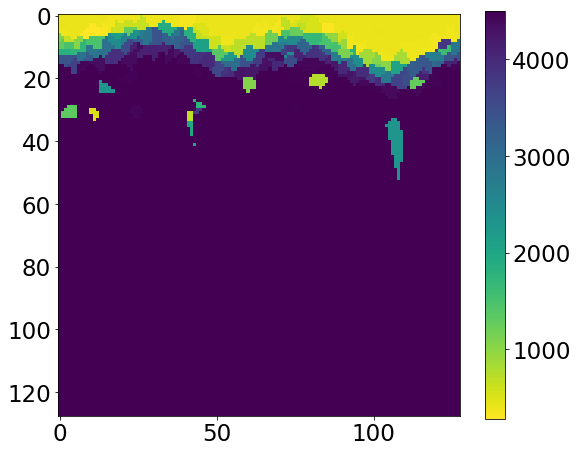

In [43]:
plt.imshow(np.flipud(Vels[100,:,:].T), cmap='viridis_r')
plt.colorbar()

> Investigate scattering coefficients.

(38636, 181)


(array([3.25000e+02, 6.19000e+02, 7.47800e+03, 2.83580e+04, 3.99670e+04,
        1.35384e+05, 3.42434e+05, 4.52809e+05, 5.52597e+05, 5.99480e+05,
        4.95602e+05, 3.65802e+05, 2.99821e+05, 2.57056e+05, 2.30803e+05,
        2.21701e+05, 2.01426e+05, 1.77432e+05, 1.62713e+05, 1.43129e+05,
        1.23056e+05, 1.10627e+05, 9.35040e+04, 8.46180e+04, 7.31400e+04,
        7.47180e+04, 6.50010e+04, 6.15990e+04, 6.03610e+04, 5.58620e+04,
        5.82410e+04, 4.93040e+04, 4.58970e+04, 4.53770e+04, 4.19620e+04,
        3.86120e+04, 3.50910e+04, 3.01120e+04, 2.78650e+04, 2.47740e+04,
        2.31030e+04, 2.38150e+04, 2.33960e+04, 2.21650e+04, 2.40590e+04,
        2.48190e+04, 2.43830e+04, 2.24120e+04, 2.42580e+04, 2.24320e+04,
        2.20450e+04, 2.11550e+04, 2.29720e+04, 2.11520e+04, 1.88880e+04,
        1.81450e+04, 1.51700e+04, 1.63360e+04, 1.41960e+04, 1.31670e+04,
        1.10030e+04, 8.25600e+03, 8.38700e+03, 8.11800e+03, 7.38000e+03,
        7.02400e+03, 6.51700e+03, 6.95200e+03, 7.23

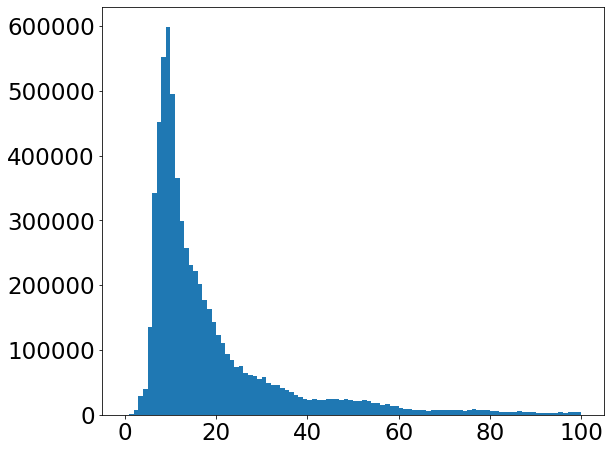

In [24]:
y_tr = np.load("Sx_2D.npy")
print(y_tr.shape)
plt.hist(y_tr.ravel(), range=[0,100], bins=100)

## 1D example.

> Make conditional Real NVP predictions.

In [29]:
# import packages
import torch
from torch import nn
from torch import distributions
from torch.nn.parameter import Parameter
from torch.autograd import Variable


#=======================================================================================================
# define normalizing flow
class RealNVP(nn.Module):
    def __init__(self, nets, nett, mask, prior):
        super(RealNVP, self).__init__()

        self.prior = prior
        self.mask = nn.Parameter(mask, requires_grad=False)
        self.t = torch.nn.ModuleList([nett() for _ in range(len(masks))])
        self.s = torch.nn.ModuleList([nets() for _ in range(len(masks))])
        self.s2 = torch.nn.ModuleList([nets2() for _ in range(len(masks))])
        self.t2 = torch.nn.ModuleList([nett2() for _ in range(len(masks))])

    def g(self, z, y):
        x = z
        for i in range(len(self.t)):
            x_ = x*self.mask[i]
            s1 = self.s[i](x_)
            s2 = self.s2[i](y)
            s = s1*s2*(1 - self.mask[i])
            t1 = self.t[i](x_)
            t2 = self.t2[i](y)
            t = t1*t2*(1 - self.mask[i])
            x = x_ + (1 - self.mask[i]) * (x * torch.exp(s) + t)
        return x

    def f(self, x, y):
        log_det_J, z = x.new_zeros(x.shape[0]), x
        for i in reversed(range(len(self.t))):
            z_ = self.mask[i] * z
            s1 = self.s[i](z_)
            s2 = self.s2[i](y)
            s = s1*s2*(1 - self.mask[i])
            t1 = self.t[i](z_)
            t2 = self.t2[i](y)
            t = t1*t2*(1 - self.mask[i])
            z = (1 - self.mask[i]) * (z - t) * torch.exp(-s) + z_
            log_det_J -= s.sum(dim=1)
        return z, log_det_J

    def log_prob(self,x,y):
        z, logp = self.f(x,y)
        return self.prior.log_prob(z) + logp

    def sample(self, z,y):
        x = self.g(z,y)
        return x



#=======================================================================================================
# restore models
flow = torch.load("../flow_final_geology.pt", map_location=lambda storage, loc: storage); # load in cpu
flow.eval();

#--------------------------------------------------------------------------------------------------------
# import training set
temp = np.loadtxt("geology_data.txt")
x_tr = temp[:,:20]
y_tr = temp[:,20:]

# standardize
mu_x = np.mean(x_tr,axis=0)
std_x = np.std(x_tr,axis=0)
x_tr = (x_tr - mu_x) / std_x

# subsampling
x_tr = np.repeat(x_tr[0:1],100, axis=0)
print(x_tr.shape)
y_tr = y_tr[::100]

# input dimension
dim_in = y_tr.shape[-1]


#=======================================================================================================
# choose an x tr
x_tr_choose = torch.from_numpy(x_tr).type(torch.FloatTensor)

z2 = np.random.multivariate_normal(np.zeros(dim_in), np.eye(dim_in), x_tr_choose.shape[0])
y2 = flow.sample(torch.from_numpy(z2).type(torch.FloatTensor), x_tr_choose).detach().cpu().numpy()


(100, 20)


(0, 3500)

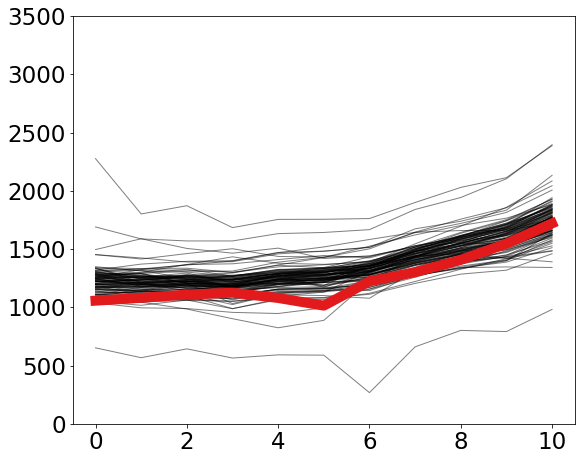

In [31]:
plt.plot(y2.T, color="k", alpha=0.5);
plt.plot(y_tr[0], color=cb2[3], lw=10);
plt.ylim([0,3500])